In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Reshape
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Reshape, LSTM, Dense, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Reshape, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Layer

In [2]:
def load_images(folder_path, image_size=(64,64)):
    data = []
    labels = []

    label = os.path.basename(folder_path)  # Extract the label from the folder name

    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):  # Check if it is a file
            img = cv2.imread(img_path)
            if img is not None:  # Check if the image was read correctly
                img = cv2.resize(img, image_size)  # Resize images to a common size
                data.append(img)
                labels.append(label)

    return np.array(data), np.array(labels)

dataset_path = r"E:\Dataset\bloodcells_dataset\Augmented2"

# Load images for each type of chest X-ray
data_basophil, labels_basophil = load_images(os.path.join(dataset_path, 'basophil'))
data_eosinophil, labels_eosinophil = load_images(os.path.join(dataset_path, 'eosinophil'))
data_erythroblast, labels_erythroblast = load_images(os.path.join(dataset_path, 'erythroblast'))
data_ig, labels_ig = load_images(os.path.join(dataset_path, 'ig'))
data_lymphocyte, labels_lymphocyte = load_images(os.path.join(dataset_path, 'lymphocyte'))
data_monocyte, labels_monocyte = load_images(os.path.join(dataset_path, 'monocyte'))
data_neutrophil, labels_neutrophil = load_images(os.path.join(dataset_path, 'neutrophil'))
data_platelet, labels_platelet = load_images(os.path.join(dataset_path, 'platelet'))

In [3]:
data_basophil.shape

(2500, 64, 64, 3)

In [4]:
# Concatenate all data and labels
All_data = np.concatenate([data_basophil, data_eosinophil, data_erythroblast, data_ig, 
                           data_lymphocyte, data_monocyte, data_neutrophil, data_platelet], axis=0)
All_labels = np.concatenate([labels_basophil, labels_eosinophil, labels_erythroblast, labels_ig, 
                             labels_lymphocyte, labels_monocyte, labels_neutrophil, labels_platelet], axis=0)

In [5]:
All_data.shape

(21841, 64, 64, 3)

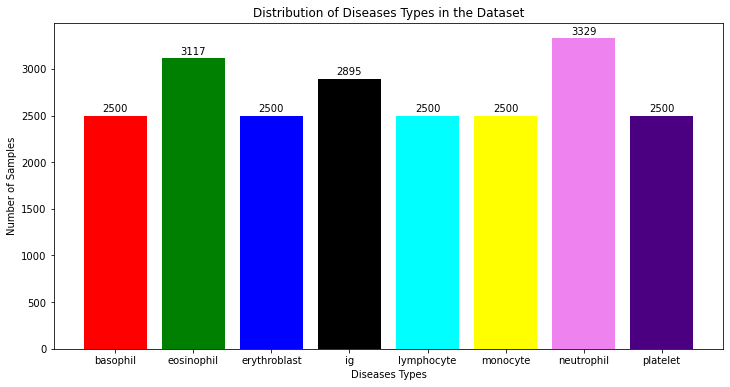

In [7]:
unique_labels, label_counts = np.unique(All_labels, return_counts=True)
plt.figure(figsize=(12, 6))
plt.bar(unique_labels, label_counts, color=['red', 'green', 'blue', 'black', 'cyan', 'yellow', 'violet', 'indigo'])
plt.xlabel('Diseases Types')
plt.ylabel('Number of Samples')
plt.title('Distribution of Diseases Types in the Dataset')
for i, count in enumerate(label_counts):
    plt.text(i, count + 20, str(count), ha='center', va='bottom')

plt.xticks(unique_labels, ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet' ])
plt.show()

In [7]:
# Normalize Pixel Values
All_data_normalized = All_data / 255.0

In [8]:
# Encode Labels
label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(All_labels)
train_data, test_data, train_labels, test_labels = train_test_split(
    All_data_normalized, all_labels_encoded, test_size=0.15, random_state=42
)

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        et = tf.nn.tanh(tf.tensordot(x, self.W, axes=(2, 0)) + self.b)
        at = tf.nn.softmax(et, axis=1)
        ot = x * at
        return tf.reduce_sum(ot, axis=1)

In [10]:
image_size = (64, 64)
num_classes = 8

In [11]:
from tensorflow.keras.models import Model
inputs = Input(shape=(image_size + (3,)))

x_1 = Conv2D(16, kernel_size=(3, 3), activation="relu",padding='same')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x_1)
x = Dropout(0.3)(x)
x = Conv2D(32, kernel_size=(3, 3), activation="relu",padding='same')(x_1)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x) 
x = Flatten()(x)

x = Reshape((1, -1))(x)

lstm_out = LSTM(50, return_sequences=True)(x)
lstm_out = Dropout(0.3)(lstm_out)  # Adding Dropout after LSTM layer

attention_output = Attention()(lstm_out)

combined_output = Add()([attention_output, tf.reduce_sum(lstm_out, axis=1)])

outputs = Dense(num_classes, activation="softmax")(combined_output)

combined_model = Model(inputs=inputs, outputs=outputs)

combined_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

checkpoint_callback = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min")
early_stopping_callback = EarlyStopping(patience=3, monitor="val_loss", mode="min", restore_best_weights=True)

combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 62, 62, 16)           448       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 31, 31, 16)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 dropout (Dropout)           (None, 31, 31, 16)           0         ['max_pooling2d[0][0]']   

In [12]:
history = combined_model.fit(
    train_data,
    train_labels,
    epochs=30,
    batch_size=16,
    validation_split=0.15,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/30
986/987 [============================>.] - ETA: 0s - loss: 0.8908 - accuracy: 0.6706

C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


987/987 [==============================] - 48s 44ms/step - loss: 0.8907 - accuracy: 0.6706 - val_loss: 0.4027 - val_accuracy: 0.8704
Epoch 2/30
987/987 [==============================] - 36s 37ms/step - loss: 0.4387 - accuracy: 0.8461 - val_loss: 0.2960 - val_accuracy: 0.9023
Epoch 3/30
987/987 [==============================] - 38s 38ms/step - loss: 0.3540 - accuracy: 0.8770 - val_loss: 0.2832 - val_accuracy: 0.9038
Epoch 4/30
987/987 [==============================] - 37s 37ms/step - loss: 0.2933 - accuracy: 0.9010 - val_loss: 0.2390 - val_accuracy: 0.9178
Epoch 5/30
987/987 [==============================] - 36s 36ms/step - loss: 0.2721 - accuracy: 0.9068 - val_loss: 0.1966 - val_accuracy: 0.9382
Epoch 6/30
987/987 [==============================] - 38s 38ms/step - loss: 0.2362 - accuracy: 0.9151 - val_loss: 0.1851 - val_accuracy: 0.9400
Epoch 7/30
987/987 [==============================] - 36s 37ms/step - loss: 0.2206 - accuracy: 0.9233 - val_loss: 0.1780 - val_accuracy: 0.9357
Epo

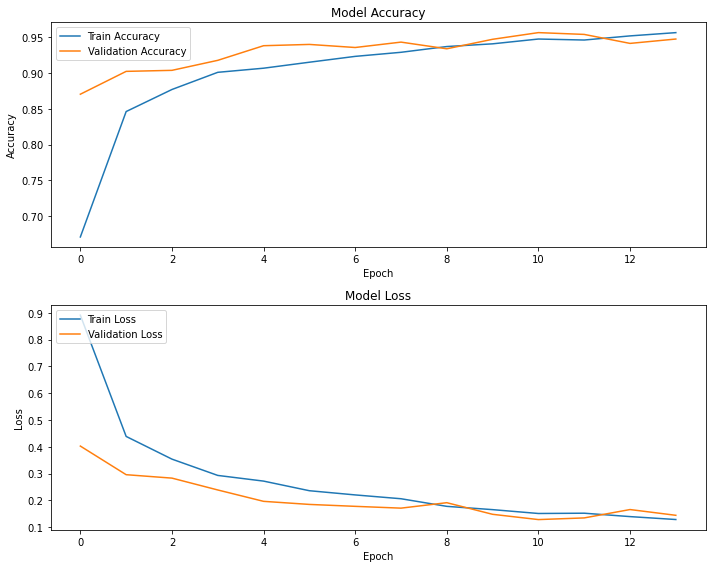

In [13]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot Accuracy
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='upper left')

# Plot Loss
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [14]:
# Evaluate the model on the test set
test_predictions1 = combined_model.predict(test_data)
test_predictions_classes1 = np.argmax(test_predictions1, axis=1)
CNN_LSTM_class_report1 = classification_report(test_labels, test_predictions_classes1, target_names=label_encoder.classes_)
print("Classification Report:\n", CNN_LSTM_class_report1)

103/103 [==============================] - 2s 14ms/step
Classification Report:
               precision    recall  f1-score   support

    basophil       0.93      0.95      0.94       334
  eosinophil       0.99      0.99      0.99       500
erythroblast       0.98      0.94      0.96       372
          ig       0.86      0.90      0.88       439
  lymphocyte       0.97      0.96      0.97       366
    monocyte       0.94      0.93      0.93       391
  neutrophil       0.97      0.96      0.97       517
    platelet       1.00      1.00      1.00       358

    accuracy                           0.95      3277
   macro avg       0.96      0.95      0.95      3277
weighted avg       0.96      0.95      0.95      3277



In [15]:
accuracy = accuracy_score(test_labels, test_predictions_classes1)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 95.45%


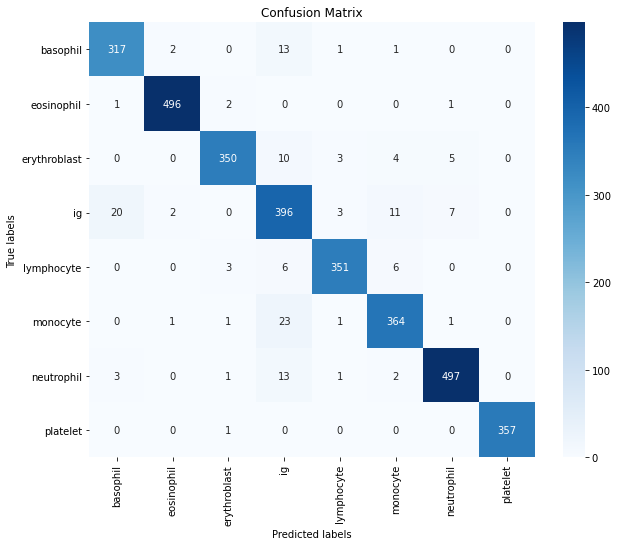

In [16]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions_classes1)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [18]:
#combined_model.save("trained_combined_model_Attention.h5")

C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
